In [1]:
import os
import toml
import multiprocessing as mp
from functools import reduce, partial

import pandas as pd
import scipy
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from pandas.plotting import lag_plot, autocorrelation_plot, bootstrap_plot, radviz

import copy
import gc

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.decomposition import PCA
from sklearn import preprocessing

from typing import List, Dict, NoReturn, Any, Callable, Union, Optional

from preproc import import_csv, new_hybrid_interpolator
from customobjs import objdict

In [2]:
%matplotlib inline
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (15, 8)

In [3]:
!ls interpolated/ | grep 20-06

NG1988812H_Maganna_Gustavo_(24-05-20)_(20-06-20)_interpolated.csv
NG1988812H_Maganna_Gustavo_(29-03-20)_(20-06-20)_interpolated.csv
NG1988812H_Maganna_Gustavo_(7-06-20)_(20-06-20)_interpolated.csv


In [4]:
y = import_csv("interpolated/NG1988812H_Maganna_Gustavo_(29-03-20)_(20-06-20)_interpolated.csv")

/Users/gml/Library/Caches/pypoetry/virtualenvs/diabetes-analysis--6n-IUK1-py3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (1,6,7,32,37) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [5]:
keyword = 'SUSPEND BEFORE LOW'
alarms  = []
for i in y.Alarm.dropna().unique().tolist():
    if keyword in i:
        alarms.append(i)
alarms

['SUSPEND BEFORE LOW ALARM, QUIET',
 'SUSPEND BEFORE LOW ALARM, PATIENT UNRESPONSIVE, MEDICAL DEVICE EMERGENCY']

In [6]:
dates = pd.unique(y.index.date)
n_total = len(dates)
print(f"Number of days in data : {len(dates)}")

Number of days in data : 87


In [7]:
n_month = 30
n_latest = 4
#month = data.loc[dates[len(dates) - n_month]:dates[-1], :] if n_month < n_total else None
latest = y.loc[dates[len(dates)- n_latest]:dates[-1], :] if n_latest < n_total else None
lday = y.loc[dates[len(dates)- 1]:dates[-1], :] if n_latest < n_total else None

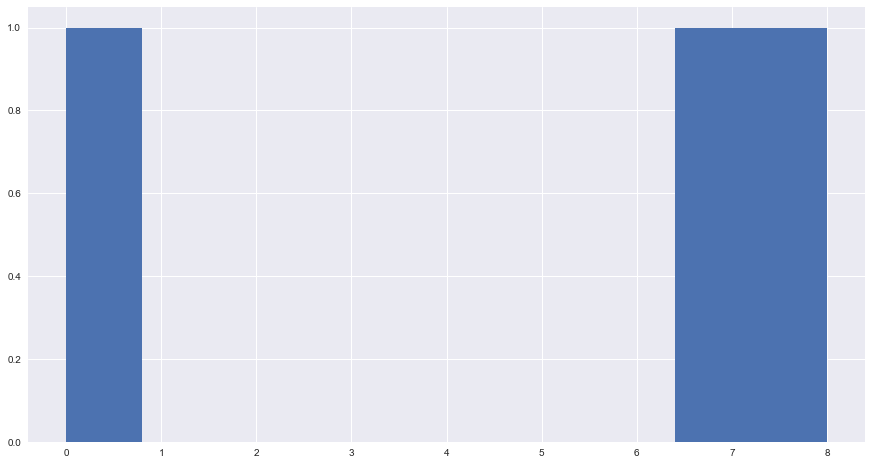

In [15]:
latest[ latest.Alarm == 'SUSPEND BEFORE LOW ALARM, QUIET' ].hour.hist()

2020-06-17    AxesSubplot(0.125,0.125;0.775x0.755)
2020-06-18    AxesSubplot(0.125,0.125;0.775x0.755)
2020-06-19    AxesSubplot(0.125,0.125;0.775x0.755)
2020-06-20    AxesSubplot(0.125,0.125;0.775x0.755)
Name: Basal Rate (U/h), dtype: object

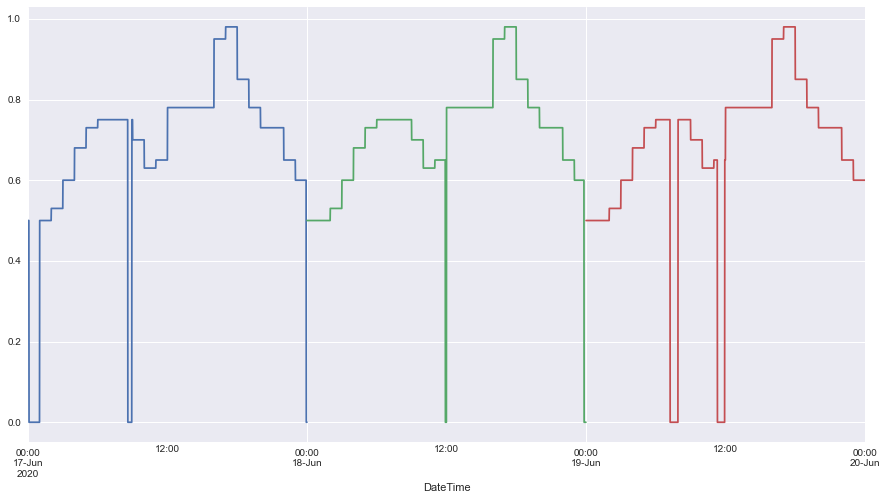

In [22]:
latest.groupby(latest.index.date)["Basal Rate (U/h)"].plot()

In [17]:
latest[latest.hour==22]["Basal Rate (U/h)"].describe()

count    1.800000e+02
mean     6.500000e-01
std      1.113320e-16
min      6.500000e-01
25%      6.500000e-01
50%      6.500000e-01
75%      6.500000e-01
max      6.500000e-01
Name: Basal Rate (U/h), dtype: float64

In [13]:
latest.columns

Index(['New Device Time', 'BG Reading (mg/dL)', 'Linked BG Meter ID',
       'Basal Rate (U/h)', 'Temp Basal Amount', 'Temp Basal Type',
       'Temp Basal Duration (h:mm:ss)', 'Bolus Type',
       'Bolus Volume Selected (U)', 'Bolus Volume Delivered (U)',
       'Bolus Duration (h:mm:ss)', 'Prime Type', 'Prime Volume Delivered (U)',
       'Alarm', 'Suspend', 'Rewind', 'BWZ Estimate (U)',
       'BWZ Target High BG (mg/dL)', 'BWZ Target Low BG (mg/dL)',
       'BWZ Carb Ratio (g/U)', 'BWZ Insulin Sensitivity (mg/dL/U)',
       'BWZ Carb Input (grams)', 'BWZ BG Input (mg/dL)',
       'BWZ Correction Estimate (U)', 'BWZ Food Estimate (U)',
       'BWZ Active Insulin (U)', 'Sensor Calibration BG (mg/dL)',
       'Sensor Glucose (mg/dL)', 'ISIG Value', 'Event Marker', 'Bolus Number',
       'Bolus Cancellation Reason', 'BWZ Unabsorbed Insulin Total (U)',
       'Final Bolus Estimate', 'Scroll Step Size', 'Insulin Action Curve Time',
       'Sensor Calibration Rejected Reason', 'Preset Bol